In [ ]:
import copy
import os
import random
import sys

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from PIL import Image
from sklearn.metrics import cohen_kappa_score, precision_score, recall_score, accuracy_score
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.transforms.functional import to_pil_image
from tqdm import tqdm
import wandb

In [ ]:
torch.cuda.empty_cache()


In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [ ]:
# Hyper Parameters
batch_size = 32
num_classes = 5  # 5 DR levels
learning_rate = 1e-4
num_epochs = 20

In [ ]:
class RetinopathyDataset(Dataset):
    def __init__(self, ann_file, image_dir, transform=None, mode='single', test=False):
        self.ann_file = ann_file
        self.image_dir = image_dir
        self.transform = transform

        self.test = test
        self.mode = mode

        if self.mode == 'single':
            self.data = self.load_data()
        else:
            self.data = self.load_data_dual()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if self.mode == 'single':
            return self.get_item(index)
        else:
            return self.get_item_dual(index)

    # 1. single image
    def load_data(self):
        df = pd.read_csv(self.ann_file)

        data = []
        for _, row in df.iterrows():
            file_info = dict()
            file_info['img_path'] = os.path.join(self.image_dir, row['img_path'])
            if not self.test:
                file_info['dr_level'] = int(row['patient_DR_Level'])
            data.append(file_info)
        return data

    def get_item(self, index):
        data = self.data[index]
        img = Image.open(data['img_path']).convert('RGB')
        if self.transform:
            img = self.transform(img)

        if not self.test:
            label = torch.tensor(data['dr_level'], dtype=torch.int64)
            return img, label
        else:
            return img

    # 2. dual image
    def load_data_dual(self):
        df = pd.read_csv(self.ann_file)

        df['prefix'] = df['image_id'].str.split('_').str[0]  # The patient id of each image
        df['suffix'] = df['image_id'].str.split('_').str[1].str[0]  # The left or right eye
        grouped = df.groupby(['prefix', 'suffix'])

        data = []
        for (prefix, suffix), group in grouped:
            file_info = dict()
            file_info['img_path1'] = os.path.join(self.image_dir, group.iloc[0]['img_path'])
            file_info['img_path2'] = os.path.join(self.image_dir, group.iloc[1]['img_path'])
            if not self.test:
                file_info['dr_level'] = int(group.iloc[0]['patient_DR_Level'])
            data.append(file_info)
        return data

    def get_item_dual(self, index):
        data = self.data[index]
        img1 = Image.open(data['img_path1']).convert('RGB')
        img2 = Image.open(data['img_path2']).convert('RGB')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        if not self.test:
            label = torch.tensor(data['dr_level'], dtype=torch.int64)
            return [img1, img2], label
        else:
            return [img1, img2]

In [ ]:
class CutOut(object):
    def __init__(self, mask_size, p=0.5):
        self.mask_size = mask_size
        self.p = p

    def __call__(self, img):
        if np.random.rand() > self.p:
            return img

        # Ensure the image is a tensor
        if not isinstance(img, torch.Tensor):
            raise TypeError('Input image must be a torch.Tensor')

        # Get height and width of the image
        h, w = img.shape[1], img.shape[2]
        mask_size_half = self.mask_size // 2
        offset = 1 if self.mask_size % 2 == 0 else 0

        cx = np.random.randint(mask_size_half, w + offset - mask_size_half)
        cy = np.random.randint(mask_size_half, h + offset - mask_size_half)

        xmin, xmax = cx - mask_size_half, cx + mask_size_half + offset
        ymin, ymax = cy - mask_size_half, cy + mask_size_half + offset
        xmin, xmax = max(0, xmin), min(w, xmax)
        ymin, ymax = max(0, ymin), min(h, ymax)

        img[:, ymin:ymax, xmin:xmax] = 0
        return img

In [ ]:
class SLORandomPad:
    def __init__(self, size):
        self.size = size

    def __call__(self, img):
        pad_width = max(0, self.size[0] - img.width)
        pad_height = max(0, self.size[1] - img.height)
        pad_left = random.randint(0, pad_width)
        pad_top = random.randint(0, pad_height)
        pad_right = pad_width - pad_left
        pad_bottom = pad_height - pad_top
        return transforms.functional.pad(img, (pad_left, pad_top, pad_right, pad_bottom))

In [ ]:
class FundRandomRotate:
    def __init__(self, prob, degree):
        self.prob = prob
        self.degree = degree

    def __call__(self, img):
        if random.random() < self.prob:
            angle = random.uniform(-self.degree, self.degree)
            return transforms.functional.rotate(img, angle)
        return img

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomCrop((256, 256)),
    SLORandomPad((200, 200)),
    FundRandomRotate(prob=0.5, degree=45),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=(0.09),contrast=0.2),
    transforms.ToTensor(),
    CutOut(mask_size=100, p=0.5),
    transforms.Normalize(mean=[0.29, 0.31, 0.36], std=[0.4, 0.35, 0.2])
])

transform_test = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.29, 0.31, 0.36], std=[0.4, 0.35, 0.2])
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


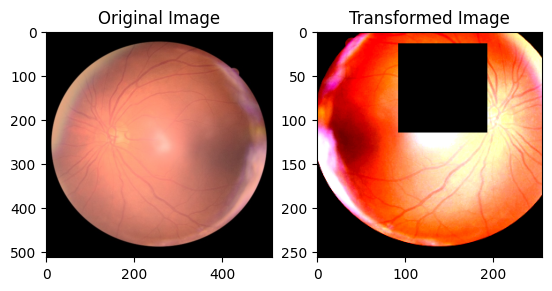

In [ ]:
import matplotlib.pyplot as plt

img_path = "University of Oulu/Deep Learning/Final Project/DeepDRiD/train/10/10_l1.jpg"  # Replace with the image path
img = Image.open(img_path)

transformed_img = transform_train(img)

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.title("Transformed Image")
plt.imshow(transformed_img.permute(1, 2, 0))

plt.show()


In [ ]:
def train_model(model, train_loader, val_loader, device, criterion, optimizer, lr_scheduler, num_epochs=25,
                checkpoint_path='model.pth'):
    best_model = model.state_dict()
    best_epoch = None
    best_val_kappa = -1.0  # Initialize the best kappa score

    # Lists for tracking metrics for visualization
    train_losses = []
    val_losses = []
    train_kappas = []
    val_kappas = []
    train_accuracies = []
    val_accuracies = []
    train_precisions = []
    val_precisions = []
    train_recalls = []
    val_recalls = []

    for epoch in range(1, num_epochs + 1):
        print(f'\nEpoch {epoch}/{num_epochs}')
        running_loss = []
        all_preds = []
        all_labels = []

        # Training phase
        model.train()
        with tqdm(total=len(train_loader), desc=f'Training', unit=' batch', file=sys.stdout) as pbar:
            for images, labels in train_loader:
                if not isinstance(images, list):
                    images = images.to(device)  # Single image case
                else:
                    images = [x.to(device) for x in images]  # Dual image case

                labels = labels.to(device)
                optimizer.zero_grad()

                outputs = model(images)
                loss = criterion(outputs, labels.long())

                loss.backward()
                optimizer.step()

                preds = torch.argmax(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                running_loss.append(loss.item())
                pbar.set_postfix({'lr': f'{optimizer.param_groups[0]["lr"]:.1e}', 'Loss': f'{loss.item():.4f}'})
                pbar.update(1)

        lr_scheduler.step()

        # Calculate epoch training metrics
        epoch_loss = sum(running_loss) / len(running_loss)
        train_metrics = compute_metrics(all_preds, all_labels)
        train_kappa, train_accuracy, train_precision, train_recall = train_metrics[:4]

        train_losses.append(epoch_loss)
        train_kappas.append(train_kappa)
        train_accuracies.append(train_accuracy)
        train_precisions.append(train_precision)
        train_recalls.append(train_recall)

        print(f'[Train] Kappa: {train_kappa:.4f} Accuracy: {train_accuracy:.4f} '
              f'Precision: {train_precision:.4f} Recall: {train_recall:.4f} Loss: {epoch_loss:.4f}')

        # WandB logging for training
#       wandb.log({
#            "epoch": epoch,
#            "train_loss": epoch_loss,
#            "train_kappa": train_kappa,
#            "train_accuracy": train_accuracy,
#            "train_precision": train_precision,
#            "train_recall": train_recall,
#            "learning_rate": optimizer.param_groups[0]["lr"]
#        })

        # Validation phase
        val_metrics, val_loss = evaluate_model(model, val_loader, device)
        val_kappa, val_accuracy, val_precision, val_recall = val_metrics[:4]

        val_losses.append(val_loss)
        val_kappas.append(val_kappa)
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)

        print(f'[Val] Kappa: {val_kappa:.4f} Accuracy: {val_accuracy:.4f} '
              f'Precision: {val_precision:.4f} Recall: {val_recall:.4f} Loss: {val_loss:.4f}')

        # WandB logging for validation
#       wandb.log({
#            "val_loss": val_loss,
#            "val_kappa": val_kappa,
#            "val_accuracy": val_accuracy,
#            "val_precision": val_precision,
#            "val_recall": val_recall
#        })

        # Save the best model
        if val_kappa > best_val_kappa:
            best_val_kappa = val_kappa
            best_epoch = epoch
            best_model = model.state_dict()
            torch.save(best_model, checkpoint_path)

    print(f'[Val] Best kappa: {best_val_kappa:.4f}, Epoch {best_epoch}')

    # Return all metrics and tracked lists

    metrics = {
        "train_kappa": train_kappa,
        "train_accuracy": train_accuracy,
        "train_precision": train_precision,
        "train_recall": train_recall,
        "train_loss": epoch_loss,
        "val_kappa": best_val_kappa,
        "val_accuracy": val_accuracy,
        "val_precision": val_precision,
        "val_recall": val_recall,
        "val_loss": val_loss,
        "best_epoch": best_epoch,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_kappas": train_kappas,
        "val_kappas": val_kappas,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
        "train_precisions": train_precisions,
        "val_precisions": val_precisions,
        "train_recalls": train_recalls,
        "val_recalls": val_recalls
    }

    return model, metrics


In [ ]:
def evaluate_model(model, test_loader, device, test_only=False, prediction_path=""):

    if not prediction_path:
        prediction_path = f"{model_name.replace('.pth', '_predictions.csv')}"
    print(f"Saving predictions to: {prediction_path}")

    model.eval()

    all_preds = []
    all_labels = []
    all_image_ids = []
    val_loss = []
    criterion = nn.CrossEntropyLoss()

    with tqdm(total=len(test_loader), desc=f'Evaluating', unit=' batch', file=sys.stdout) as pbar:
        for i, data in enumerate(test_loader):

            if test_only:
                images = data
            else:
                images, labels = data

            if not isinstance(images, list):
                images = images.to(device)  # single image case
            else:
                images = [x.to(device) for x in images]  # dual images case

            if not test_only:
                labels = labels.to(device)

            with torch.no_grad():
                outputs = model(images)
                preds = torch.argmax(outputs, 1)

                if not test_only:
                    # Calculate validation loss
                    loss = criterion(outputs, labels.long())
                    val_loss.append(loss.item())

            if not isinstance(images, list):
                # single image case
                all_preds.extend(preds.cpu().numpy())
                image_ids = [
                    os.path.basename(test_loader.dataset.data[idx]['img_path']) for idx in
                    range(i * test_loader.batch_size, i * test_loader.batch_size + len(images))
                ]
                all_image_ids.extend(image_ids)
                if not test_only:
                    all_labels.extend(labels.cpu().numpy())
            else:
                # dual images case
                for k in range(2):
                    all_preds.extend(preds.cpu().numpy())
                    image_ids = [
                        os.path.basename(test_loader.dataset.data[idx][f'img_path{k + 1}']) for idx in
                        range(i * test_loader.batch_size, i * test_loader.batch_size + len(images[k]))
                    ]
                    all_image_ids.extend(image_ids)
                    if not test_only:
                        all_labels.extend(labels.cpu().numpy())

            pbar.update(1)

    # Save predictions to csv file for Kaggle online evaluation
    if test_only:
        df = pd.DataFrame({
            'ID': all_image_ids,
            'TARGET': all_preds
        })
        try:
            df.to_csv(prediction_path, index=False)
            print(f'[Test] Predictions saved to {os.path.abspath(prediction_path)}')
        except Exception as e:
            print(f"Failed to save predictions to {prediction_path}: {e}")
    else:
        metrics = compute_metrics(all_preds, all_labels)
        avg_val_loss = sum(val_loss) / len(val_loss) if val_loss else 0.0
        return metrics, avg_val_loss


In [ ]:
def compute_metrics(preds, labels, per_class=False):
    kappa = cohen_kappa_score(labels, preds, weights='quadratic')
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted', zero_division=0)
    recall = recall_score(labels, preds, average='weighted', zero_division=0)

    # Calculate and print precision and recall for each class
    if per_class:
        precision_per_class = precision_score(labels, preds, average=None, zero_division=0)
        recall_per_class = recall_score(labels, preds, average=None, zero_division=0)
        return kappa, accuracy, precision, recall, precision_per_class, recall_per_class

    return kappa, accuracy, precision, recall

In [ ]:
import torch
import torch.nn as nn

class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()

        self.query = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.key = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.value = nn.Conv2d(in_dim, in_dim, kernel_size=1)

        self.softmax = nn.Softmax(dim=-1)

        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, channels, height, width = x.size()

        query = self.query(x).view(batch_size, -1, height * width).permute(0, 2, 1)
        key = self.key(x).view(batch_size, -1, height * width)
        value = self.value(x).view(batch_size, -1, height * width)

        attention_scores = torch.bmm(query, key)
        attention_map = self.softmax(attention_scores)

        out = torch.bmm(value, attention_map.permute(0, 2, 1))
        out = out.view(batch_size, channels, height, width)

        out = self.gamma * out + x
        return out


In [ ]:
class MyModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.62):
        super().__init__()

        self.backbone = models.resnet34(pretrained=True)
        self.backbone.fc = nn.Identity()  # Remove the original classification layer

        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import copy

class MyDualModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super(MyDualModel, self).__init__()

        backbone = models.resnet34(pretrained=True)
        backbone.fc = nn.Identity()

        self.backbone1 = copy.deepcopy(backbone)
        self.backbone2 = copy.deepcopy(backbone)

        self.self_attention = SelfAttention(in_dim=512)

        # Fully connected layers for classification
        self.fc = nn.Sequential(
            nn.Linear(512 * 2, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, images):
        image1, image2 = images


        x1 = self.backbone1(image1)
        x2 = self.backbone2(image2)

        x1 = x1.unsqueeze(-1).unsqueeze(-1)
        x2 = x2.unsqueeze(-1).unsqueeze(-1)

        x1 = self.self_attention(x1)
        x2 = self.self_attention(x2)

        x1 = x1.view(x1.size(0), -1)
        x2 = x2.view(x2.size(0), -1)
        x = torch.cat((x1, x2), dim=1)

        x = self.fc(x)
        return x


In [ ]:
import pandas as pd
import os

def save_run_to_excel(metrics, model_name, params, output_file=""):

    if not output_file:
        output_file = f"history_{os.path.basename(model_name).replace('.pth', '.csv')}"

    run_data = {
        "Model Name": model_name,
        "Batch Size": params["batch_size"],
        "Learning Rate": params["learning_rate"],
        "Epochs": params["num_epochs"],
        "Best Epoch": metrics["best_epoch"],
        "Train Kappa": metrics["train_kappa"],
        "Train Accuracy": metrics["train_accuracy"],
        "Train Precision": metrics["train_precision"],
        "Train Recall": metrics["train_recall"],
        "Train Loss": metrics["train_loss"],
        "Val Kappa": metrics["val_kappa"],
        "Val Accuracy": metrics["val_accuracy"],
        "Val Precision": metrics["val_precision"],
        "Val Recall": metrics["val_recall"],
        "Val Loss": metrics["val_loss"]
    }

    new_run = pd.DataFrame([run_data])

    if os.path.exists(output_file):

        try:
            existing_data = pd.read_csv(output_file)
            updated_data = pd.concat([existing_data, new_run], ignore_index=True)
        except Exception as e:
            print(f"Error reading existing file {output_file}: {e}")
            updated_data = new_run
    else:

        updated_data = new_run

    try:
        updated_data.to_csv(output_file, index=False)
        print(f"Run data successfully saved to {output_file}")
    except Exception as e:
        print(f"Error saving run data to {output_file}: {e}")


In [ ]:
import matplotlib.pyplot as plt

def plot_training_results(metrics, save_path="training_results_Task C-Self_Attention.png"):

    train_losses = metrics.get("train_losses", [])
    val_losses = metrics.get("val_losses", [])
    train_kappas = metrics.get("train_kappas", [])
    val_kappas = metrics.get("val_kappas", [])
    train_accuracies = metrics.get("train_accuracies", [])
    val_accuracies = metrics.get("val_accuracies", [])
    train_precisions = metrics.get("train_precisions", [])
    val_precisions = metrics.get("val_precisions", [])
    train_recalls = metrics.get("train_recalls", [])
    val_recalls = metrics.get("val_recalls", [])

    epochs = range(1, len(train_losses) + 1)

    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    fig.suptitle("Training and Validation Metrics from Task A", fontsize=16)

    #Training Loss vs Validation Loss
    axes[0, 0].plot(epochs, train_losses, label="Train Loss", color='blue')
    axes[0, 0].plot(epochs, val_losses, label="Val Loss", color='orange')
    axes[0, 0].set_title("Training vs Validation Loss")
    axes[0, 0].set_xlabel("Epochs")
    axes[0, 0].set_ylabel("Loss")
    axes[0, 0].legend()

    #Validation Kappa Score
    axes[0, 1].plot(epochs, train_kappas, label="Train Kappa", color='blue')
    axes[0, 1].plot(epochs, val_kappas, label="Val Kappa", color='green')
    axes[0, 1].set_title("Kappa Score")
    axes[0, 1].set_xlabel("Epochs")
    axes[0, 1].set_ylabel("Kappa")
    axes[0, 1].legend()

    #Training Accuracy vs Validation Accuracy
    axes[1, 0].plot(epochs, train_accuracies, label="Train Accuracy", color='blue')
    axes[1, 0].plot(epochs, val_accuracies, label="Val Accuracy", color='orange')
    axes[1, 0].set_title("Accuracy")
    axes[1, 0].set_xlabel("Epochs")
    axes[1, 0].set_ylabel("Accuracy")
    axes[1, 0].legend()

    #Training Precision vs Validation Precision
    axes[1, 1].plot(epochs, train_precisions, label="Train Precision", color='blue')
    axes[1, 1].plot(epochs, val_precisions, label="Val Precision", color='orange')
    axes[1, 1].set_title("Precision")
    axes[1, 1].set_xlabel("Epochs")
    axes[1, 1].set_ylabel("Precision")
    axes[1, 1].legend()

    #Training Recall vs Validation Recall
    axes[2, 0].plot(epochs, train_recalls, label="Train Recall", color='blue')
    axes[2, 0].plot(epochs, val_recalls, label="Val Recall", color='orange')
    axes[2, 0].set_title("Recall")
    axes[2, 0].set_xlabel("Epochs")
    axes[2, 0].set_ylabel("Recall")
    axes[2, 0].legend()

    axes[2, 1].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(save_path)
    print(f"Plots saved to {save_path}")
    plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(model, val_loader, device, class_names, save_path="confusion_matrix_task C-Self_Attention.png"):

    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            if isinstance(images, list):
                images = [img.to(device) for img in images]
            else:
                images = images.to(device)

            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, labels=np.arange(len(class_names)))

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(save_path)
    print(f"Confusion matrix saved to {save_path}")
    plt.show()


/home/kavi/Documents/GitHub/myvenv-Tensor/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kavi/Documents/GitHub/myvenv-Tensor/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MyDualModel(
  (backbone1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

/tmp/ipykernel_119022/3298962958.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_name, map_location='cpu')



[Val] Kappa: 0.8088 Accuracy: 0.6950 Precision: 0.6864 Recall: 0.6950 Loss: 0.8799
[Val] Best kappa: 0.8398, Epoch 14
Run data successfully saved to history_model_dual_run_taskC_Self_Attention.csv
Saving predictions to: ./model_dual_run_taskC_Self_Attention_predictions.csv
Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.95 batch/s]
[Test] Predictions saved to /home/kavi/Documents/GitHub/model_dual_run_taskC_Self_Attention_predictions.csv
Saving predictions to: ./model_dual_run_taskC_Self_Attention_predictions.csv
Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.13 batch/s]
[Test] Predictions saved to /home/kavi/Documents/GitHub/model_dual_run_taskC_Self_Attention_predictions.csv
Plots saved to task_C-Se

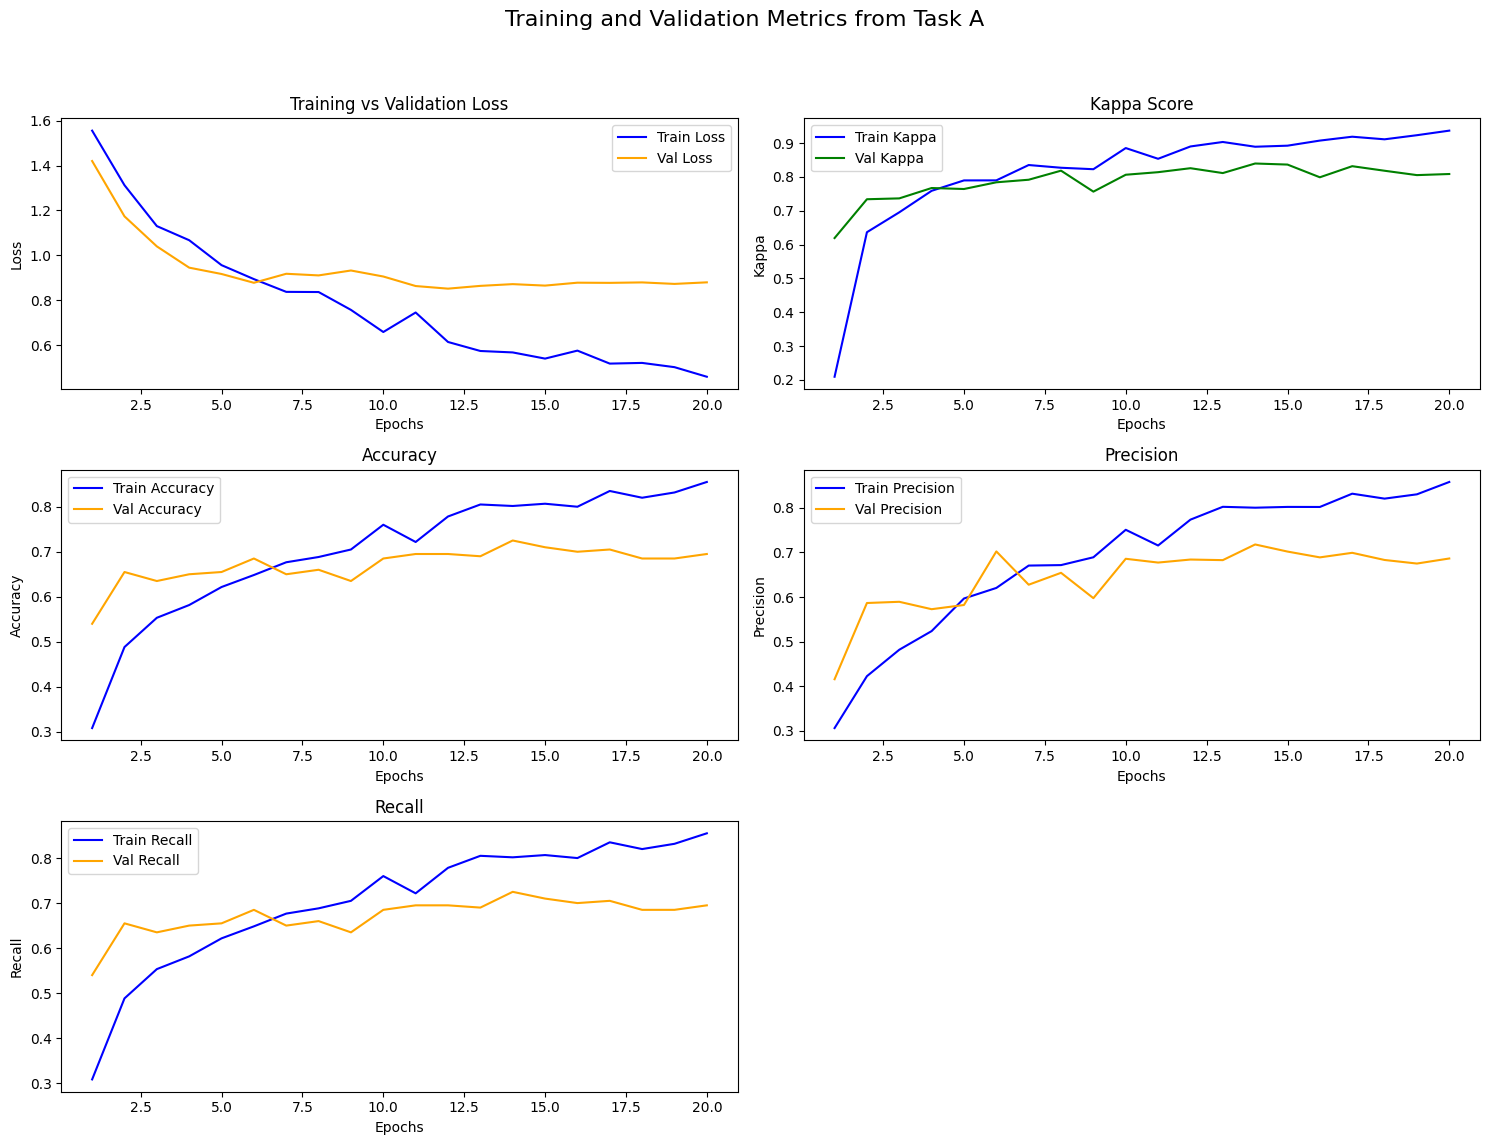

Confusion matrix saved to task_C-Self_Attention_confusion_matrix.png


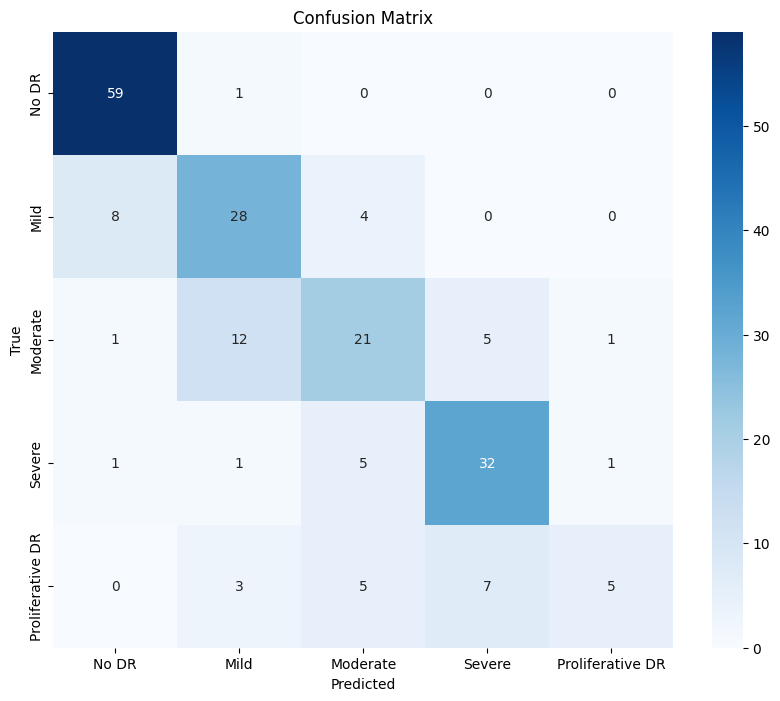

In [ ]:
if __name__ == '__main__':

#    wandb.init(
#        project="Results_Comparison",
#        entity="kavindamadhujith-University of Oulu3545",
#        name="Task C - Self Attention",
#        resume=False
#    )

    #mode = 'single'  # forward single image to the model each time
    mode = 'dual'  # forward two images of the same eye to the model and fuse the features

    assert mode in ('single', 'dual')


    model_name = f"./model_{mode}_run_taskC_Self_Attention.pth"

    # Define the model
    if mode == 'single':
        model = MyModel()
    else:
        model = MyDualModel()

    print(model, '\n')
    print('Pipeline Mode:', mode)

    # Create datasets
    train_dataset = RetinopathyDataset(
        'University of Oulu/Deep Learning/Final Project/DeepDRiD/train.csv',
        'University of Oulu/Deep Learning/Final Project/DeepDRiD/train',
        transform_train, mode
    )
    val_dataset = RetinopathyDataset(
        'University of Oulu/Deep Learning/Final Project/DeepDRiD/val.csv',
        'University of Oulu/Deep Learning/Final Project/DeepDRiD/val',
        transform_test, mode
    )
    test_dataset = RetinopathyDataset(
        'University of Oulu/Deep Learning/Final Project/DeepDRiD/test.csv',
        'University of Oulu/Deep Learning/Final Project/DeepDRiD/test',
        transform_test, mode, test=True
    )

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,num_workers=4)

    # Define the weighted CrossEntropyLoss
    criterion = nn.CrossEntropyLoss()

    # Use GPU device if possible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Device:', device)

    # Move model to device
    model = model.to(device)

    # Optimizer and Learning rate scheduler
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=0.01)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    #lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)



    try:
        # Train the model and retrieve metrics
        model, metrics = train_model(
            model, train_loader, val_loader, device, criterion, optimizer,
            lr_scheduler=lr_scheduler, num_epochs=num_epochs,
            checkpoint_path=model_name
        )

        params = {
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "num_epochs": num_epochs
        }
        save_run_to_excel(metrics, model_name, params)

        # Load the pretrained checkpoint
        state_dict = torch.load(model_name, map_location='cpu')
        model.load_state_dict(state_dict, strict=True)

        # Make predictions on testing set and save the prediction results
        evaluate_model(model, test_loader, device, test_only=True)

        # Make predictions on testing set and save the prediction results
        evaluate_model(model, test_loader, device, test_only=True)

        # Call visualization
        plot_training_results(metrics, save_path="task_C-Self_Attention_training_results.png")

        # Define class names for your DR levels
        class_names = ["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"]

        # Plot confusion matrix
        plot_confusion_matrix(model, val_loader, device, class_names, save_path="task_C-Self_Attention_confusion_matrix.png")

    except Exception as e:
        print(f"An error occurred: {e}")

#    finally:

#        wandb.finish()
